<h1>Local Symmetry Strength Quantification</h2>

<i> Gonzalo Muradás Odriozola 02-2023 </i>

Local Symmetry Strength refers to the quantification of how symmetric a selected area of an image is. The goal of this notebook is to create a function that returns a float value from 0 to 1 indicating the strength of symmetry on a specific bounding box. 1 for perfect symmetry, 0 for complete asymmetry.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp


This image of a butterfly is chosen for this study based on its almost perfect symmetry, size and initial rotation

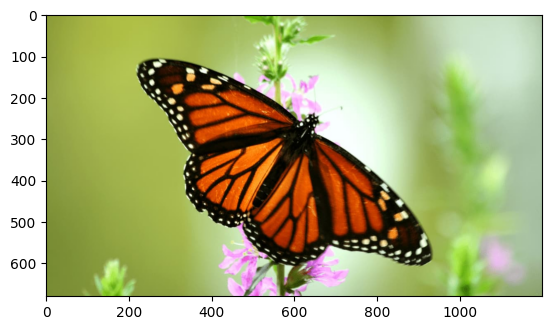

In [2]:
# Read Image
img = cv2.imread('butterfly.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.imshow(img)
plt.show()

<h2>Bounding Box</h2>
The bounding box will be given as input for the image, the axis of symmetry will be in the center of the rectangle, either vertically or horizontally. Note that the axis is not perfeclty located at the center, as human subjects will not be able to place it perfectly either.

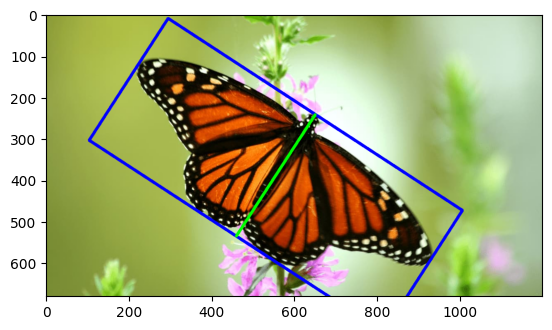

In [3]:
# Returns a list with all the transformmed keypoints
def transformKeypoints(keypoints, rotationMatrix):
    result = []
    for keypoint in keypoints:
        rotatedPoint = rotationMatrix.dot(np.array(keypoint + (1,)))
        result.append((int(rotatedPoint[0]),int(rotatedPoint[1])))

    return result

# Keypoints for the bounding box and axis of symmetry
startVertex = (165,230)
bbWidthAndLength = (850, 350)
rotationDegrees = -33
keyp = ([startVertex, (startVertex[0]+bbWidthAndLength[0],startVertex[1]), (startVertex[0],startVertex[1]+bbWidthAndLength[1]), (startVertex[0]+bbWidthAndLength[0],startVertex[1]+bbWidthAndLength[1]), (startVertex[0]+bbWidthAndLength[0]//2,startVertex[1]), (startVertex[0]+bbWidthAndLength[0]//2, startVertex[1]+bbWidthAndLength[1])])
# Rotating keypoints
rotationMatrix = cv2.getRotationMatrix2D((img.shape[1]//2,img.shape[0]//2),rotationDegrees,1)
rotkeyp = transformKeypoints(keyp, rotationMatrix)

# Drawing the lines for the bounding box
display = img.copy()
cv2.line(display, rotkeyp[0], rotkeyp[1], [0,0,255], 5)
cv2.line(display, rotkeyp[0], rotkeyp[2], [0,0,255], 5)
cv2.line(display, rotkeyp[3], rotkeyp[2], [0,0,255], 5)
cv2.line(display, rotkeyp[3], rotkeyp[1], [0,0,255], 5)
# Drawing the symmetry axis
cv2.line(display, rotkeyp[4], rotkeyp[5], [0,255,0], 5)

# Display
plt.imshow(display)
plt.show()


<h2>Operating Image</h2>
First the image is rotated and cropped to fit the bounding box.

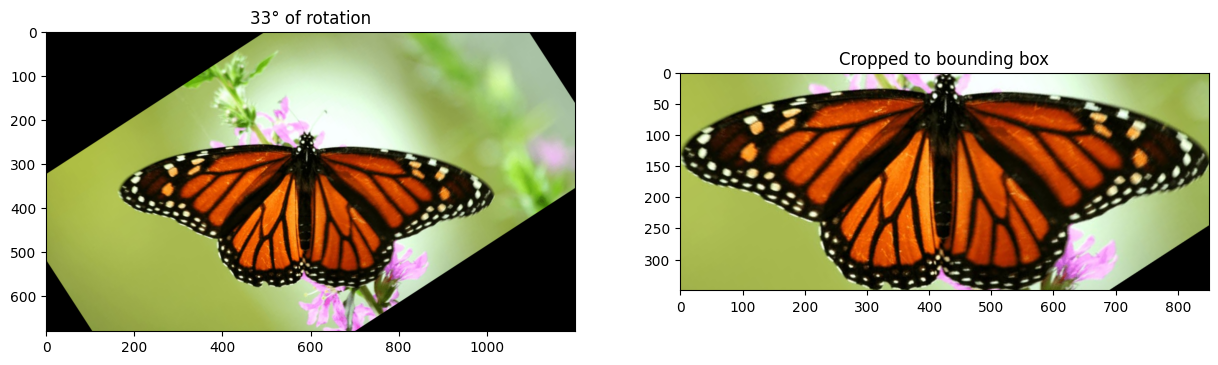

In [4]:
# Rotating the image
rotationMatrix = cv2.getRotationMatrix2D((img.shape[1]//2,img.shape[0]//2),-rotationDegrees,1)
rotate = cv2.warpAffine(img,rotationMatrix,(img.shape[1], img.shape[0])) 

# Cropping the rotated image
startPoint = startVertex
length = bbWidthAndLength
cropped = rotate[startPoint[1]:startPoint[1]+length[1], startPoint[0]:startPoint[0]+length[0]]

# Display
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(rotate), ax[0].set_title(f'{-rotationDegrees}° of rotation')
ax[1].imshow(cropped), ax[1].set_title(f'Cropped to bounding box')
plt.show()

<h2>Separating into sides</h2>

To see the symmetries the symilarities between the sides will be measured, to do this the image is separated into right and left side, and one of them is mirrored.

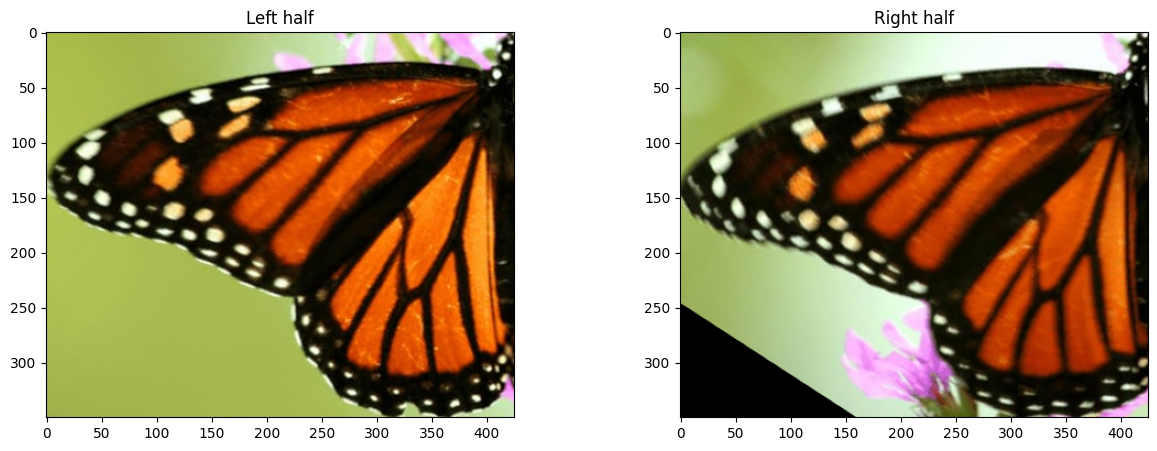

In [5]:
# Cropping right and left halves
leftHalf = cropped[:, :length[0]//2]
rightHalf = cropped[:, length[0]//2:]
# Mirroring the right side
rightHalf = cv2.flip(rightHalf, 1)

# Black and White
BWleft = cv2.cvtColor(leftHalf, cv2.COLOR_RGB2GRAY)
BWright = cv2.cvtColor(rightHalf, cv2.COLOR_RGB2GRAY)

# Display
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(leftHalf), ax[0].set_title(f'Left half')
ax[1].imshow(rightHalf), ax[1].set_title(f'Right half')
plt.show()

As it can be seen in the picture above, the right half of the butterfly has a black corner caused by the rotation. Since the algorithms that are going to be used to check the similarities between the halves are based on vector distance, this will create an area that is very much non symmetrical. To solve this, the same corner is applied on the left half of the image.

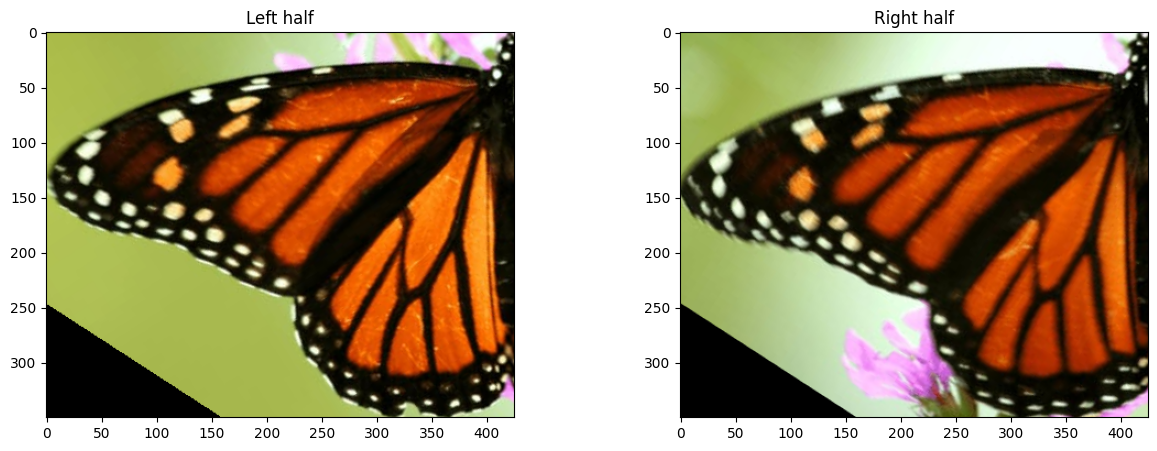

In [13]:
# Copies the pixels = [0,0,0] on both sides of the image
def copyMask(img1, img2):
    for i in range(img1.shape[0]):
        for j in range(img1.shape[0]):
            if (img1[i,j] == [0,0,0]).all():
                img2[i,j] = [0,0,0]
            if (img2[i,j] == [0,0,0]).all():
                img1[i,j] = [0,0,0]


# Copying the black pixels
copyMask(rightHalf,leftHalf)

# Display
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(leftHalf), ax[0].set_title(f'Left half')
ax[1].imshow(rightHalf), ax[1].set_title(f'Right half')
plt.show()

<h2>Difference Visualization</h2>

By substracting the right half to the left half of the image we can visualize the areas were they differ. The brighter the pixel the more they differ.

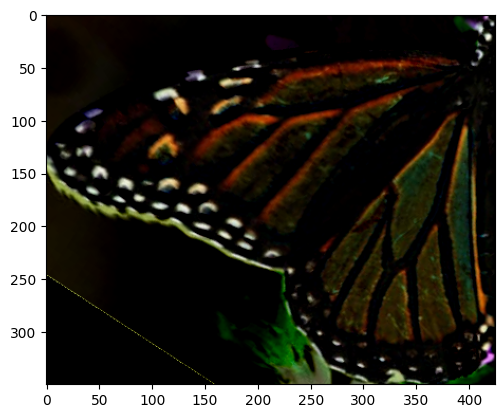

In [14]:
# Substract arrays
diff = cv2.subtract(leftHalf, rightHalf)

# Display
plt.imshow(diff)

<h2>Lower resolution</h2>
By reducing the resolution of the image the pixels will be averaged to their surroundings. This will make the score for the symmetry less pixel-dependent.

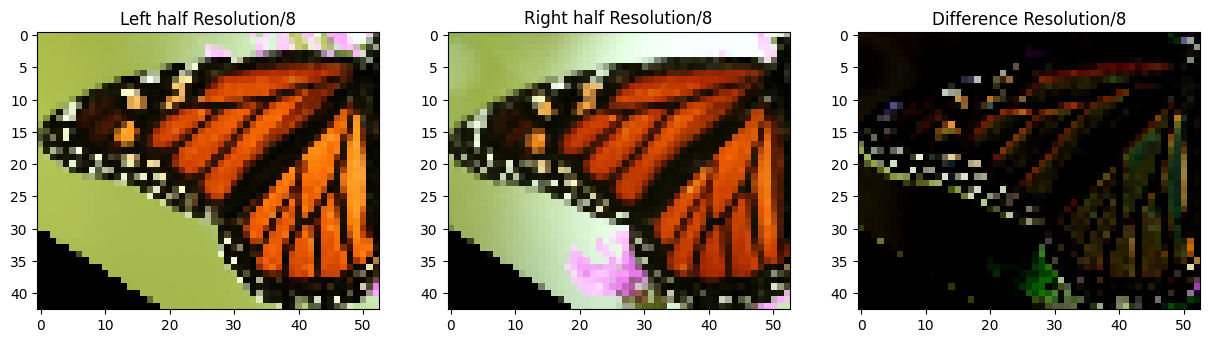

In [18]:
ratio = 8
# Reducing resolution
lowDefLeft = cv2.resize(leftHalf, (leftHalf.shape[1]//ratio, leftHalf.shape[0]//ratio))
lowDefRight = cv2.resize(rightHalf, (leftHalf.shape[1]//ratio, leftHalf.shape[0]//ratio))
# Calculating difference
diff = cv2.subtract(lowDefLeft, lowDefRight)

# Display
_, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(lowDefLeft), ax[0].set_title(f'Left half Resolution/{ratio}')
ax[1].imshow(lowDefRight), ax[1].set_title(f'Right half Resolution/{ratio}')
ax[2].imshow(diff), ax[2].set_title(f'Difference Resolution/{ratio}')
plt.show()

<h2>Measuring Similarity</h2>
Similarity refers to a metric that measures how equal two images are. There are multiple studies and metrics used for this specific task. Next a function is developed to obtain the similarity between two equal sized images according to the following metrics.

1. Mean Squared Error (MSE)
2. Root Mean Squared Error (RMSE)
3. Peak Signal-to-Noise Ratio (PSNR)
4. Structural Similarity Index (SSIM)
5. Universal Quality Image Index (UQI)
6. Multi-scale Structural Similarity Index (MS-SSIM)
7. Erreur Relative Globale Adimensionnelle de Synthèse (ERGAS)
8. Spatial Correlation Coefficient (SCC)
9. Relative Average Spectral Error (RASE)
10. Spectral Angle Mapper (SAM)
11. Visual Information Fidelity (VIF)
 

In [10]:
def getMetrics(title, img1, img2):
    result = pd.DataFrame({
        'MSE': [mse(img1, img2)],
        'RMSE': [rmse(img1, img2)],
        'PSNR': [psnr(img1, img2)],
        'UQI': [uqi(img1, img2)],
        'MSSSIM': [msssim(img1, img2)],
        'ERGAS': [ergas(img1, img2)],
        'SCC': [scc(img1, img2)],
        # 'RASE': [rase(img1, img2)],  # CANNOT DIVIDE BY 0
        'SAM': [sam(img1, img2)],
        # 'VIF':[vifp(img1, img2)],  # DOES NOT WORK WITH LOWER RESOLUTIONS
        'SSIM': [ssim(img1, img2)]
    }, index=[title])

    return result

Now the statistics are used to calculate the similarities between different pairs of images to get multiple basis:
1. Black vs Left: Similarity between a complete black image and the left side of the butterfly, this will serve as a basis for non symmetric images.
2. Left vs Left: Similarity between the left image and itself, this is used to see what a perfect score looks like in that metric.
3. Left vs Right: Similarity between the left and right side of the image, used to measure strength of symmetry.
4. Left vs Right low definition: Similarity between the left and right side of the image in lower definition, used to measure strength of symmetry.

https://ece.uwaterloo.ca/~z70wang/publications/uqi.html    <- UQI

In [11]:
onlyBlack = np.ones(rightHalf.shape).astype(np.uint8)

blackLeft = getMetrics('Black v Left', leftHalf, onlyBlack)
leftLeft = getMetrics('Left v Left', leftHalf, leftHalf)
leftRight = getMetrics('Left v Right', leftHalf,rightHalf)
lowDefLeftRigth = getMetrics('Low Def Left v Right', lowDefLeft,lowDefRight)

In [12]:
df = pd.concat([blackLeft,leftLeft,leftRight,lowDefLeftRigth])

df

,MSE,RMSE,PSNR,UQI,MSSSIM,ERGAS,SCC,SAM,SSIM
Black v Left,14291.030956,119.545100,6.580168,0.033302,0.104782+0.000000j,61967.966621,0.000000,0.739447,"(0.1312872955308019, 0.5064493130571766)"
Left v Left,0.000000,0.000000,inf,1.000000,1.000000+0.000000j,0.000000,0.912757,0.000000,"(1.0, 1.0)"
Left v Right,3247.443034,56.986341,13.015388,0.698228,0.649415+0.000000j,42374.758504,0.015985,0.464595,"(0.5172476027495794, 0.5529206801480296)"
Low Def Left v Right,3211.442446,56.669590,13.063802,0.757904,0.884019+0.000000j,32319.588863,0.271041,0.462311,"(0.5956590403262484, 0.6153621509810461)"
